<a href="https://colab.research.google.com/github/kayfay/data_viz/blob/master/cohort_analysis/cohort_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A cohort is a group of users who share something in common,
sign-up date, first purchase month, birth date, acquisition, or channel.
Cohort anaysis tracks these groups over time to identify trends, repeat
behaviors (purchases, engagement, amount spent, etc.), and monitor 
customer revenu and retention. 

 * Grubhub ordering food, AirBnB booking stays.
 * Engagements; "likes" "favorites".
 * Stickiness: loyalty, (to keep current customers), for startups an 
indicator of product-market fit.
 * To visualize user retention/churn and a basic understanding of
lifetime value.

[Greg Reda: Cohort Analysis with Python](http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/)

# This section imports and creates Cohorts for the [Global Sales 2016 Data](https://docs.google.com/spreadsheets/d/1HcBg6Y42Qsytm7LazGD8Ksx2c-sLllb4kNW76nnTuD8/edit?usp=sharing)

In [0]:
!pip install --upgrade -q gspread

In [302]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('global_superstore_2016').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
orders=pd.DataFrame(rows[1:], columns=rows[:1][0])

# Transform time into timestamps
for col in ['Order Date', 'Ship Date']:  
  orders[col] = pd.to_datetime(orders[col])


# Create Order Periods
orders.insert(loc=3,
              column='Order Period',
              value=Orders['Order Date'].apply(lambda x: pd.Timestamp(x).strftime("%Y-%m")))

print("Cells: {0} \nRows and Columns: {1}".format(orders.size, orders.shape))
orders.head(2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Cells: 1282250 
Rows and Columns: (51290, 25)


,Row ID,Order ID,Order Date,Order Period,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0,$62.15,40.77,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical


In [303]:
# Cohort groups based on user's first order
orders.set_index('Customer ID', inplace=True)

orders.insert(loc=1, 
  column='Cohort Group',
  value=orders.groupby(level=0)['Order Date'].min() \
              .apply(lambda x: pd.Timestamp(x).strftime("%Y-%m")))

orders.head(2)
# orders.reset_index(inplace=True) # moved to display table

,Row ID,Cohort Group,Order ID,Order Date,Order Period,Ship Date,Ship Mode,Customer Name,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,
AB-100151402,40098,2012-02,CA-2014-AB10015140-41954,2014-11-11,2014-11,2014-11-13,First Class,Aaron Bergman,Consumer,73120,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0,$62.15,40.77,High
JR-162107,26341,2014-02,IN-2014-JR162107-41675,2014-02-05,2014-02,2014-02-07,Second Class,Justin Ritter,Corporate,,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical


In [0]:
orders.reset_index(inplace=True) # display table with index and remove

In [305]:
# Aggregate users, orders, amounts spent 
import numpy as np
# Group by CohortGroup & OrderPeriod
grouped = orders.groupby(['Cohort Group', 'Order Period'])

# convert Sales to numeric from currency
orders['Sales'] = pd.to_numeric(orders['Sales'] \
                                .replace('[\$,)]', '', regex=True),
                                 downcast='float')

# count unique users, orders and total revenue per Group & Period
cohorts = grouped.agg({'Customer ID': pd.Series.nunique,
                        'Order ID': pd.Series.nunique,
                        'Sales': np.sum})

# name column
cohorts.rename(columns={'Customer ID': "Total Users",
                        'Order ID': "Total Orders"}, inplace=True)

cohorts.head(2)

Total Users  Total Orders         Sales
Cohort Group Order Period                                         
2012-01      2012-01               215           216  98898.531250
             2012-03                 1             1    212.519989

In [307]:
# Label Cohort Period for each CohortGroup with a helper function
def cohort_period(df, cohort_group):
  """
  Create a Cohort Period column, as Nth period of first purchase
  -------
  Example: To get 3rd month per user; 
  df.sort(['Customer ID', 'Order Date'], inplace=True)
  df = df.groupby('Customer ID').apply(cohort_period)
  df[df['Cohort Period'] == 3]
  -------
  """
  df[cohort_group] = np.arange(len(df)) + 1
  return df

cohorts = cohorts.groupby(level=0).apply(cohort_period, 'Order Period')

cohorts.head()

Total Users  ...  Order Period
Cohort Group Order Period               ...              
2012-01      2012-01               215  ...             1
             2012-03                 1  ...             2
             2012-04                 3  ...             3
             2012-05                 2  ...             4
             2012-06                 4  ...             5

[5 rows x 4 columns]

In [0]:
# Error testing of data points to corresponding order values in new cohorts
x = orders[(orders['Cohort Group'] == '2014-01') \
           & (orders['Order Period'] == '2014-01')]
y = cohorts.loc[['2014-01', '2014-01']]

assert((x['Customer ID'].nunique() == y['Total Users']).any())
assert((x['Sales'].sum().round(2) == y['Sales'].round(2)).any())
assert((x['Order ID'].nunique() == y['Total Orders']).any())

x = orders[(orders['Cohort Group'] == '2015-01') \
          & (orders['Order Period'] == '2015-09')]
y = cohorts.loc[['2015-01', '2015-09']]

assert((x['Customer ID'].nunique() == y['Total Users']).any())
assert((x['Sales'].sum().round(2) == y['Sales'].round(2)).any())
assert((x['Order ID'].nunique() == y['Total Orders']).any())

x = orders[(orders['Cohort Group'] == '2015-05') \
          & (orders['Order Period'] == '2015-09')]
y = cohorts.loc[['2015-05', '2015-09']]

assert((x['Customer ID'].nunique() == y['Total Orders']).any())
assert((x['Sales'].sum().round(2) == y['Sales'].round(2)).any())
assert((x['Order ID'].nunique() == y['Total Orders']).any())

# Visualization of Cohort groups with high sales

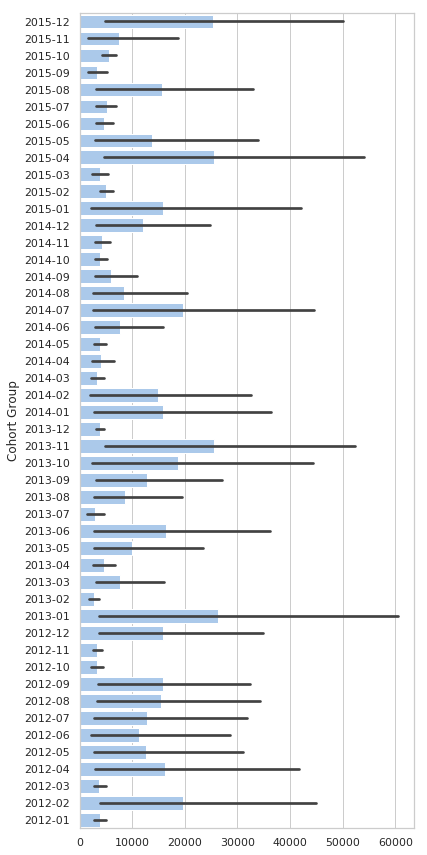

In [310]:
# View sales by cohort
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 15))
plt_ords = orders.sort_values('Cohort Group', ascending=False)
sns.set_color_codes("pastel")
sales = cohorts['Sales'].get_values()
sns.barplot(x=sales, y=plt_ords['Cohort Group'], 
            data = plt_ords, color="b")